# Инструкционное дообучение LLM: сравнение LoRA и QLoRA

В этом ноутбуке мы проведем эксперимент по сравнительному дообучению модели **LLaMA-2-7B** на задаче бинарной классификации *sentiment analysis* (датасет **SST-2**) двумя способами: с помощью **LoRA** и **QLoRA**.

**LoRA (Low-Rank Adaptation)** - метод параметр-эффективного дообучения, при котором исходные веса модели замораживаются, а в ряде слоев добавляются небольшие тензоры низкого ранга, обучаемые для новой задачи. Это существенно сокращает число обучаемых параметров и требования к памяти для хранения градиентов.

**QLoRA (Quantized LoRA)** - сочетает идели LoRA и 4-битной квантизации модели. Базовые веса LLM при загрузке квантируются до 4 бит (формат NF4), что резко снижает потребление VRAM, после чего к модели также применяются адаптеры LoRA. Кватование немного увеличивает сложность вычислений, но позволяет обучаеть большие модели на GPU меньшего объема.

## Установка и импорт необходимых библиотек

In [1]:
# !pip install transformers accelerate bitsandbytes peft datasets scikit-learn matplotlib

После установки импортируем требуемые классы и функции.

In [48]:
import time, torch, numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


## Загрузка датасета SST-2 и подготовка данных

Немного информации про сам датасет:
Датасет **SST-2 (Stanford Sentiment Treebank)** - это коллекция предложений из отзывов фильмах, размеченных по тональности: **0 = Negative (негативный отзыв), 1 = Positive (положительный отзыв).** Мы загрузим версию SST-2 из набора задач GLUE через библиотеку Datasets.

In [4]:
dataset = load_dataset("glue", "sst2")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})


In [5]:
print("Train samples:", len(dataset["train"]))
print("Validation samples:", len(dataset["validation"]))

Train samples: 67349
Validation samples: 872


Перед обучением превратим каждый пример в формат **инструкции** и **ответа**. Модель LLaMA-2-7B – это авто-регрессионная языковая модель, поэтому мы будем формулировать задачу классификации как задачу генерации правильного ответа ("Positive" или "Negative") на заданную инструкцию.

Каждому примеру создадим текст вида:

```
<s>[INST] Classify the sentiment of this text as Positive or Negative:\n{sentence} [/INST]
```

где вместо `Positive` будет правильный класс для данного предложения (Positive или `Negative`).

In [6]:
base_model_name = "meta-llama/Llama-2-7b-hf"
tokenizer = AutoTokenizer.from_pretrained(base_model_name, use_auth_token=True)

/home/hazratkulov.z/.local/lib/python3.10/site-packages/transformers/models/auto/tokenization_auto.py:898: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


In [7]:
tokenizer.pad_token = tokenizer.eos_token

In [9]:
INST = "<s>[INST] Classify the sentiment of this text as Positive or Negative:\n{sentence} [/INST]"
POS_TXT, NEG_TXT = " Positive", " Negative"
pos_id = tokenizer(POS_TXT, add_special_tokens=False).input_ids[0]
neg_id = tokenizer(NEG_TXT, add_special_tokens=False).input_ids[0]

In [10]:
def to_instruction(example):
    prompt_ids  = tokenizer.encode(INST.format(sentence=example["sentence"]), add_special_tokens=False)
    label_ids   = tokenizer.encode("\n" + (POS_TXT if example["label"] else NEG_TXT),
                                   add_special_tokens=False) + [tokenizer.eos_token_id]
    return {
        "input_ids": prompt_ids + label_ids,
        "labels":    [-100]*len(prompt_ids) + label_ids
    }

In [11]:
train_data = dataset["train"].map(to_instruction, remove_columns=dataset["train"].column_names)
val_data   = dataset["validation"].map(to_instruction, remove_columns=dataset["validation"].column_names)

In [12]:
print("Пример форматированного текста инструкции:")
example_ids = train_data[0]["input_ids"]
print(tokenizer.decode(example_ids, skip_special_tokens=True))

Пример форматированного текста инструкции:
[INST] Classify the sentiment of this text as Positive or Negative:
hide new secretions from the parental units  [/INST] 
 Negative


Для эффективной работы `Trainer` нам нужен коллатор, который будет формировать батчи, дополнять последовательности до одинаковой длины и обеспечивать правильное маскирование паддингов. Мы реализуем свой collate-функцию: она паддирует `input_ids` до максимальной длины в батче, используя `tokenizer.pad_token_id` (что у нас равен `<eos>`, и аналогично паддирует `labels` заполнителем `-100` (чтобы дополнительные токены не влияли на лосс). Также формируется `attention_mask`, где реальные токены = 1, паддинг = 0. 

In [13]:
def data_collator(batch):
    max_len = max(len(e["input_ids"]) for e in batch)
    input_ids, labels, attn = [], [], []
    for e in batch:
        pad = max_len - len(e["input_ids"])
        input_ids.append(e["input_ids"] + [tokenizer.pad_token_id]*pad)
        labels.append(    e["labels"]     + [-100]*pad)
        attn.append([1]*len(e["input_ids"]) + [0]*pad)
    return {
        "input_ids":      torch.tensor(input_ids, dtype=torch.long),
        "labels":         torch.tensor(labels, dtype=torch.long),
        "attention_mask": torch.tensor(attn, dtype=torch.long)
    }

## Дообучение модели с помощью LoRA

Теперь настроим и проведем fine-tuning с использованием LoRA. Будем брать предобученную модель LLaMA-2-7B и добавлять LoRA-адаптеры.

### 1. Загрузка базовой модели LLaMA-2-7B (FP16)

In [14]:
model_lora = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    use_auth_token=True,
    device_map="auto",
    torch_dtype=torch.float16
)

# Отключаем кэширование ключей/значений (необходимо при применении gradient checkpointing)
model_lora.config.use_cache = False
# Включаем gradient checkpointing для экономии памяти
model_lora.gradient_checkpointing_enable()

/home/hazratkulov.z/.local/lib/python3.10/site-packages/transformers/models/auto/auto_factory.py:476: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [15]:
allocated = torch.cuda.memory_allocated() / 1024**2
reserved = torch.cuda.memory_reserved() / 1024**2
print(f"После загрузки модели: занято на GPU ~{allocated:.2f} MB (reserved: {reserved:.2f} MB)")

После загрузки модели: занято на GPU ~12852.51 MB (reserved: 12856.00 MB)


### 2. Настройка LoRA и обертка модели

In [16]:
lora_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj",
                    "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)
model_lora = get_peft_model(model_lora, lora_config)
model_lora.print_trainable_parameters()

trainable params: 35,782,656 || all params: 6,774,198,272 || trainable%: 0.5282


Это означает, что только ~35.78 млн параметров будут обновляться во время обучения (это порядка 0.52% от всех ~6.7 млрд параметров модели), то есть все остальные параметры заморожены. Такая огромная экономия в числе обучаемых параметров делает обучение значительно более дешевым и быстрым.

### 3. Настройка TrainingArguments и Trainer для LoRA

In [19]:
training_args = TrainingArguments(
    output_dir="lora-sst2",
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    num_train_epochs=1,
    learning_rate=5e-5,
    warmup_ratio=0.05,
    lr_scheduler_type="cosine",
    fp16=True,
    optim="paged_adamw_8bit",
    gradient_checkpointing=True,
    logging_steps=10,
    report_to="none"
)

In [20]:
trainer_lora = Trainer(
    model=model_lora,
    train_dataset=train_data,
    eval_dataset=None,
    tokenizer=tokenizer,
    data_collator=data_collator,
    args=training_args
)

/tmp/ipykernel_55295/3163607902.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_lora = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


### 4. Обучение LoRA-модели (замер времени и VRAM)

In [21]:
torch.cuda.reset_peak_memory_stats()
start_time = time.time()
trainer_lora.train()
end_time = time.time()
train_time = end_time - start_time

# Замер пикового потребления VRAM
peak_mem = torch.cuda.max_memory_reserved() / 1024**2

print(f"\nLoRA training time: {train_time:.2f} seconds")
print(f"LoRA peak VRAM usage: {peak_mem:.2f} MB")

Step,Training Loss
10,4.626000
20,4.410000
30,3.572300
40,1.862400
50,0.271900
60,0.157800
70,0.160800
80,0.152000
90,0.114200
100,0.050700



LoRA training time: 1914.73 seconds
LoRA peak VRAM usage: 16658.00 MB


### 5. Оценка модели LoRA на validation-наборе

После обучения проведем оценку, используя отложенную валидационную выборку (872 примера).

In [22]:
from tqdm import tqdm

In [23]:
@torch.no_grad()
def label_logprob(model, prompt_ids, label_ids):
    ids = torch.tensor(prompt_ids + label_ids, device=device).unsqueeze(0)
    logits = model(ids).logits[0]              # [seq, vocab]
    logp = 0.0
    for i, tok in enumerate(label_ids):
        logp += torch.log_softmax(logits[len(prompt_ids)+i-1], dim=-1)[tok]
    return logp.item()

In [24]:
@torch.no_grad()
def classify(model, sentence: str) -> int:
    prompt_ids = tokenizer.encode(INST.format(sentence=sentence), add_special_tokens=False)
    lp_pos = label_logprob(model, prompt_ids, pos_ids)
    lp_neg = label_logprob(model, prompt_ids, neg_ids)
    return int(lp_pos > lp_neg)

In [25]:
pos_ids = tokenizer.encode(" Positive", add_special_tokens=False)
neg_ids = tokenizer.encode(" Negative", add_special_tokens=False)

In [26]:
model_lora.eval()
y_true, y_pred = [], []

for example in tqdm(dataset["validation"]):
    y_true.append(example["label"])
    y_pred.append(classify(model_lora, example["sentence"]))

100%|██████████| 872/872 [01:05<00:00, 13.33it/s]


In [27]:
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="macro")
print(f"Accuracy: {acc:.4f} | F1-macro: {f1:.4f}")

Accuracy: 0.9541 | F1-macro: 0.9541


In [49]:
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification report:\n",
      classification_report(y_true, y_pred, target_names=["Negative","Positive"]))

Confusion matrix:
 [[424   4]
 [ 36 408]]

Classification report:
               precision    recall  f1-score   support

    Negative       0.92      0.99      0.95       428
    Positive       0.99      0.92      0.95       444

    accuracy                           0.95       872
   macro avg       0.96      0.95      0.95       872
weighted avg       0.96      0.95      0.95       872



### 6. Замер скорости инференса (tokens/s) для LoRA

Измерим, с какой скоростью наша дообученная модель генерирует текст. Это важно, чтобы сравнить, не влияет ли 4-битное квантование (в QLoRA) на скорость вывода. 


Для замера возьмем один пример (произвольный текст) и попросим модель сгенерировать, скажем, 50 новых токенов. Будем засекать время генерации и вычислим количество токенов в секунду. 


Чтобы тест не зависел от специфики классификации, можно взять простой запрос, например начать сказку "Once upon a time," – и пусть модель продолжит. Таким образом, модель с LoRA (которая, хоть и обучалась на классификации, все еще обладает базовыми возможностями генерации текста) выдаст продолжение. 

Посчитаем, сколько токенов выдаст модель и за какое время, а затем выведем скорость в токенах/с.

In [28]:
test_prompt = "Once upon a time,"
inputs = tokenizer(test_prompt, return_tensors="pt").to(device)

start_time = time.time()
output_ids = model_lora.generate(**inputs, max_new_tokens=50, pad_token_id=tokenizer.eos_token_id)
end_time = time.time()
elapsed = end_time - start_time

tokens_generated = output_ids.shape[1] - inputs["input_ids"].shape[1]
tps = tokens_generated / elapsed
print(f"LoRA inference speed: {tokens_generated} tokens in {elapsed:.2f} s, = {tps:.2f} tokens/s")

LoRA inference speed: 50 tokens in 1.75 s, = 28.51 tokens/s


Наконец, после завершения всех экспериментов с LoRA, освободим память GPU, удалив модель. Это важно, чтобы обеспечить корректный замер памяти для QLoRA и избежать переполнения GPU.

In [29]:
lora_history = [(log["step"], log["loss"]) 
    for log in trainer_lora.state.log_history 
    if "loss" in log]

del model_lora, trainer_lora
torch.cuda.empty_cache()

## Дообучение модели с помощью QLoRA

Теперь выполним аналогичные шаги, но с использованием QLoRA – то есть загрузим модель LLaMA-2-7B в 4-битном сжатии (int4), добавим такие же LoRA-адаптеры и обучим. Ожидаем, что качество на SST-2 получится не хуже, чем у обычной LoRA, а потребление VRAM – значительно ниже.

### 1. Загрузка модели LLaMA-2-7B в 4-битном режиме

In [30]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)
model_qlora = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    use_auth_token=True,
    device_map="auto",
    quantization_config=bnb_config,
    torch_dtype=torch.float16
)
model_qlora.config.use_cache = False
model_qlora.gradient_checkpointing_enable()

/home/hazratkulov.z/.local/lib/python3.10/site-packages/transformers/models/auto/auto_factory.py:476: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [31]:
model_qlora = prepare_model_for_kbit_training(model_qlora)

model_qlora = get_peft_model(model_qlora, lora_config)
model_qlora.print_trainable_parameters()

trainable params: 35,782,656 || all params: 6,774,198,272 || trainable%: 0.5282


In [32]:
allocated = torch.cuda.memory_allocated() / 1024**2
reserved = torch.cuda.memory_reserved() / 1024**2
print(f"После загрузки QLoRA модели: занято на GPU ~{allocated:.2f} MB (reserved: {reserved:.2f} MB)")

После загрузки QLoRA модели: занято на GPU ~4629.06 MB (reserved: 13208.00 MB)


### 2. Настройка Trainer и обучение (QLoRA)

In [36]:
training_args_qlora = TrainingArguments(
    output_dir="qlora-sst2",
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    learning_rate=5e-5,
    warmup_ratio=0.05,
    lr_scheduler_type="cosine",
    num_train_epochs=1,
    logging_steps=10,
    fp16=True,
    optim="paged_adamw_8bit",
    gradient_checkpointing=True,
    report_to="none"
)

In [37]:
trainer_qlora = Trainer(
    model=model_qlora,
    train_dataset=train_data,
    eval_dataset=None,
    tokenizer=tokenizer,
    data_collator=data_collator,
    args=training_args_qlora
)

/tmp/ipykernel_55295/3696885191.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_qlora = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Теперь запустим обучение QLoRA-модели, аналогично засечем время и пиковое потребление памяти.

In [38]:
torch.cuda.reset_peak_memory_stats()
start_time = time.time()
trainer_qlora.train()
end_time = time.time()
train_time_q = end_time - start_time
peak_mem_q = torch.cuda.max_memory_reserved() / 1024**2

print(f"\nQLoRA training time: {train_time_q:.2f} seconds")
print(f"QLoRA peak VRAM usage: {peak_mem_q:.2f} MB")

Step,Training Loss
10,3.464300
20,2.952500
30,1.634900
40,0.328600
50,0.143600
60,0.127200
70,0.124200
80,0.104300
90,0.101900
100,0.092000



QLoRA training time: 3919.50 seconds
QLoRA peak VRAM usage: 13452.00 MB


### 3. Оценка модели QLoRA на validation-наборе

In [39]:
model_qlora.eval()
qlora_y_true, qlora_y_pred = [], []

for example in tqdm(dataset["validation"]):
    qlora_y_true.append(example["label"])
    qlora_y_pred.append(classify(model_qlora, example["sentence"]))

100%|██████████| 872/872 [03:22<00:00,  4.31it/s]


In [41]:
acc = accuracy_score(qlora_y_true, qlora_y_pred)
f1  = f1_score(qlora_y_true, qlora_y_pred, average="macro")
print(f"Accuracy: {acc:.4f} | F1-macro: {f1:.4f}")

Accuracy: 0.9541 | F1-macro: 0.9541


In [50]:
print("Confusion matrix:\n", confusion_matrix(qlora_y_true, qlora_y_pred))
print("\nClassification report:\n",
      classification_report(qlora_y_true, qlora_y_pred, target_names=["Negative","Positive"]))

Confusion matrix:
 [[420   8]
 [ 32 412]]

Classification report:
               precision    recall  f1-score   support

    Negative       0.93      0.98      0.95       428
    Positive       0.98      0.93      0.95       444

    accuracy                           0.95       872
   macro avg       0.96      0.95      0.95       872
weighted avg       0.96      0.95      0.95       872



### 4. Замер скорости инференса для QLoRA

In [42]:
inputs = tokenizer(test_prompt, return_tensors="pt").to(device)
start_time = time.time()
output_ids = model_qlora.generate(**inputs, max_new_tokens=50, pad_token_id=tokenizer.eos_token_id)
end_time = time.time()
elapsed_q = end_time - start_time
tokens_generated = output_ids.shape[1] - inputs["input_ids"].shape[1]
tps_q = tokens_generated / elapsed_q
print(f"QLoRA inference speed: {tokens_generated} tokens in {elapsed_q:.2f} s, = {tps_q:.2f} tokens/s")

QLoRA inference speed: 50 tokens in 1.87 s, = 26.75 tokens/s


In [43]:
qlora_history = [(log["step"], log["loss"])
     for log in trainer_qlora.state.log_history 
     if "loss" in log]

del model_qlora, trainer_qlora
torch.cuda.empty_cache()

## Сравнение результатов: LoRA vs QLoRA

### График функции потерь во время обучения

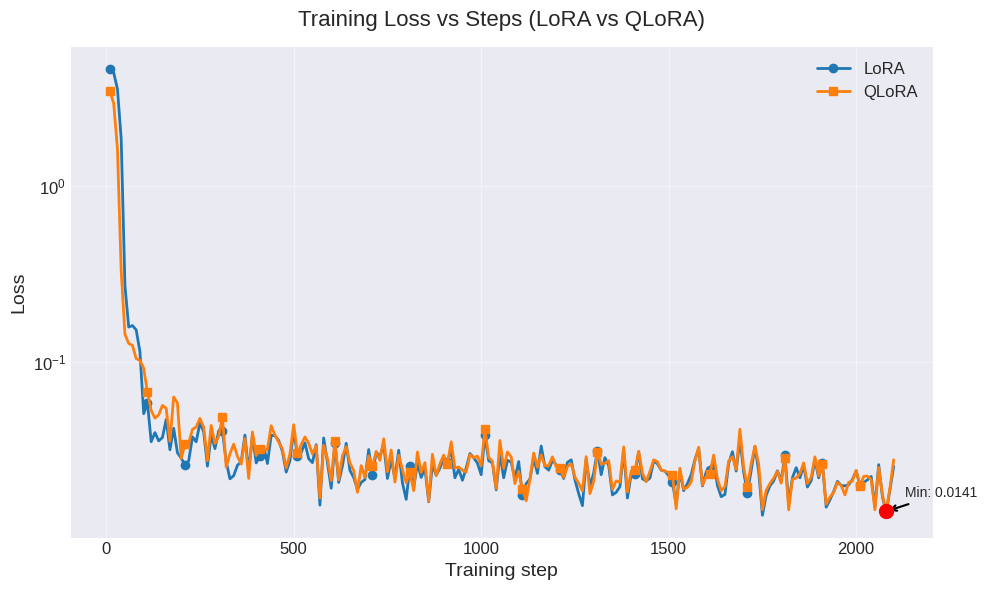

In [45]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-darkgrid')

lora_steps, lora_loss = zip(*lora_history)
qlora_steps, qlora_loss = zip(*qlora_history)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(lora_steps,  lora_loss,  label="LoRA",
        linewidth=2, marker='o', markevery=10)
ax.plot(qlora_steps, qlora_loss, label="QLoRA",
        linewidth=2, marker='s', markevery=10)

ax.set_yscale('log')

ax.set_xlabel("Training step", fontsize=14)
ax.set_ylabel("Loss", fontsize=14)
ax.set_title("Training Loss vs Steps (LoRA vs QLoRA)", fontsize=16, pad=15)

ax.tick_params(axis='both', which='major', labelsize=12)

min_idx = qlora_loss.index(min(qlora_loss))
ax.scatter(qlora_steps[min_idx], qlora_loss[min_idx],
           color='red', s=100, zorder=5)
ax.annotate(f"Min: {qlora_loss[min_idx]:.4f}",
            xy=(qlora_steps[min_idx], qlora_loss[min_idx]),
            xytext=(qlora_steps[min_idx]+50, qlora_loss[min_idx]*1.2),
            arrowprops=dict(arrowstyle="->", lw=1.5))

ax.legend(fontsize=12, loc='upper right')
ax.grid(alpha=0.4)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig("training_loss.png", format="png", dpi=300, bbox_inches="tight")
plt.show()